In [1]:
import datetime
import geemap, ee
import geopandas as gpd

from rasterio.enums import Resampling
from conflict_monitoring_ntl.satellites import SDGSat

In [2]:
try:
    ee.Initialize()
except ee.ee_exception.EEException:
    ee.Authenticate()
    ee.Initialize()

In [3]:
%load_ext autoreload
%autoreload 2

## Administrative Unit in Focus - Ayod (South Sudan)

Since SDGSat tiles don't cover the whole country, I can only focus on certain administrative levels.

In [4]:
countries = ee.FeatureCollection("FAO/GAUL/2015/level2")
ayod = countries.filter(ee.Filter.eq('ADM2_NAME', 'Ayod'))

# necessary for SDGSat
gdf = geemap.ee_to_gdf(ayod)

In [5]:
# gdf.to_file("ayod.shp", driver="ESRI Shapefile")

## Retrieve Layers

### Global Human Settlement - Population Grid

Info here: [https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_POP](https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_POP)

In [6]:
ghs_pop_2020 = ee.Image('JRC/GHSL/P2023A/GHS_POP/2020')
ayod_ghs_pop = ghs_pop_2020.clip(ayod)

# convert to xarray
ghs_xds = geemap.ee_to_xarray(
    ayod_ghs_pop,
    geometry=ayod.geometry(),
    projection=ayod_ghs_pop.projection()
)

In [7]:
test = ghs_xds.isel(time=0)

In [8]:
test.population_count

<xarray.DataArray 'population_count' (X: 1726, Y: 1821)> Size: 13MB
[3143046 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-01-01
  * X        (X) float64 14kB 3.005e+06 3.005e+06 ... 3.178e+06 3.178e+06
  * Y        (Y) float64 15kB 1.111e+06 1.111e+06 ... 9.288e+05 9.287e+05
Attributes:
    id:             population_count
    data_type:      {'type': 'PixelType', 'precision': 'double'}
    dimensions:     [360820, 180000]
    crs:            PROJCS["World_Mollweide", \n  GEOGCS["WGS 84", \n    DATU...
    crs_transform:  [100, 0, -18041000, 0, -100, 9000000]

2025-10-12 11:46:57,005 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-12 11:46:57,191 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-12 11:46:57,234 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-12 11:46:57,284 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-12 11:46:57,293 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-12 11:46:57,323 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.goo

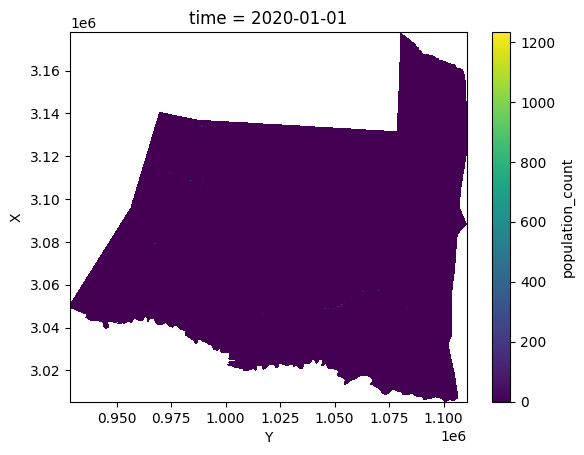

In [9]:
test.population_count.plot()

### Black Marble (VIIRS) - Annual

Info here: [https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V22...](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V22?_gl=1*1j836rr*_up*MQ..*_ga*MjAxNDkwODc4NC4xNzYwMjU0NDA5*_ga_SM8HXJ53K2*czE3NjAyNTQ0MDkkbzEkZzAkdDE3NjAyNTQ0MDkkajYwJGwwJGgw)

In [10]:
bm_pop_2020 = ee.Image("NOAA/VIIRS/DNB/ANNUAL_V22/20240101")
ayod_bm_pop = bm_pop_2020.clip(ayod)

# convert to xarray
bm_xds = geemap.ee_to_xarray(
    ayod_bm_pop,
    geometry=ayod.geometry(),
    projection=ayod_bm_pop.projection()
)

In [11]:
bm_xds

<xarray.Dataset> Size: 5MB
Dimensions:         (time: 1, lon: 414, lat: 355)
Coordinates:
  * time            (time) datetime64[ns] 8B 2024-01-01
  * lon             (lon) float64 3kB 30.21 30.22 30.22 ... 31.93 31.93 31.94
  * lat             (lat) float64 3kB 8.995 8.991 8.987 ... 7.529 7.525 7.52
Data variables:
    average         (time, lon, lat) float32 588kB ...
    average_masked  (time, lon, lat) float32 588kB ...
    cf_cvg          (time, lon, lat) float32 588kB ...
    cvg             (time, lon, lat) float32 588kB ...
    maximum         (time, lon, lat) float32 588kB ...
    median          (time, lon, lat) float32 588kB ...
    median_masked   (time, lon, lat) float32 588kB ...
    minimum         (time, lon, lat) float32 588kB ...
Attributes:
    crs:      EPSG:4326

### SDGSat

In [12]:
gdf = gpd.read_file("../data/shapes/admin_level/south_sudan/ayod/ayod.shp")
date_range = [datetime.date(2024, 12, 24)]

In [13]:
sdgsat = SDGSat()
sdgsat_xds = sdgsat.raster(gdf, date_range, variable="PL")

In [14]:
sdgsat_xds

<xarray.Dataset> Size: 3GB
Dimensions:      (x: 19093, y: 16376, time: 1)
Coordinates:
  * x            (x) float64 153kB 30.21 30.21 30.21 30.21 ... 31.94 31.94 31.94
  * y            (y) float64 131kB 9.0 9.0 9.0 9.0 ... 7.517 7.517 7.516 7.516
  * time         (time) object 8B 2024-12-24
    spatial_ref  int64 8B 0
Data variables:
    PL           (time, y, x) float64 3GB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:             Area
    FOOTPRINT:                 POLYGON ((30.082952 5.878082, 31.484902 6.1304...
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        27
    STATISTICS_MEAN:           1.0113468741894
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         0.26302655832739
    STATISTICS_VALID_PERCENT:  68.03
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 PL
    _FillValue:                nan

#### Radiance Conversion and Band Scaling

- **L** denotes the radiance intensity at the entrance pupil of the sensor.
- **L** is measured in units of **W/m²/sr/µm** (watts per square meter per steradian per micron).
- **DN** represents the original digital number (pixel value) of the image.
- **Gain** is the amplification factor; **Bias** is the offset for radiometric calibration.

##### Radiance Calculation

$$
L = DN \times \text{Gain} + \text{Bias}
$$

Where:
- $Gain = 8.832$
- $Bias = 1.67808$

##### Conversion to `nW/cm²/sr`

To convert GLI band radiance to the brightness unit `nW/cm²/sr`(same as Black Marble), multiply by the bandwidth (in microns) and a SI scaling factor.

- Bandwidth: $0.466\,\mu\text{m}$.

$$
\text{Radiance}_{(\text{nW}/\text{cm}^2/\text{sr})} = L_{(\text{W}/\text{m}^2/\text{sr}/\mu\text{m})} \times 10^5 \times \text{bandwidth}_{\mu\text{m}}
$$

In [ ]:
# TODO: change the scale

## Reproject and Resample to Common Grid

In [15]:
sdgsat_xds = sdgsat_xds.rio.reproject_match(
    bm_xds.rename({'lon': 'x', 'lat': 'y'}),  # since func can only read x-y
    resampling=Resampling.average
)

In [17]:
sdgsat_xds

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, x: 414, y: 355)
Coordinates:
  * time         (time) object 8B 2024-12-24
    spatial_ref  int64 8B 0
  * x            (x) float64 3kB 30.21 30.22 30.22 30.23 ... 31.93 31.93 31.94
  * y            (y) float64 3kB 8.995 8.991 8.987 8.983 ... 7.529 7.525 7.52
Data variables:
    PL           (time, y, x) float64 1MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:             Area
    FOOTPRINT:                 POLYGON ((30.082952 5.878082, 31.484902 6.1304...
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        27
    STATISTICS_MEAN:           1.0113468741894
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         0.26302655832739
    STATISTICS_VALID_PERCENT:  68.03
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 PL
    _FillValue:                nan

In [18]:
# TODO: stack them to the same raster

## Analysis